In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [97]:
df = pd.read_excel('E:/MyWorks/Data analyst/Data Training/Survepi.xlsx')

In [99]:
df_cholera = df[df['maladie'] == 'CHOLERA']

In [101]:
df['date'] = pd.to_datetime(df['Annee'].astype(str) + df['numsem'].astype(str).str.zfill(2) + '0', format='%Y%U%w')
df.set_index('date', inplace=True)

# Sélection de la colonne 'totalcas'
df_totalcas = df['totalcas'].resample('M').sum()


C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_21012\3546328946.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_totalcas = df['totalcas'].resample('M').sum()


In [103]:
# Normalisation des données
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_totalcas.values.reshape(-1, 1))

In [105]:
# Création des séquences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)

In [107]:
# Division des données en ensembles d'entraînement et de test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [109]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

C:\Users\Peter ciya\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - loss: 0.2443 - val_loss: 0.0281
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1893 - val_loss: 0.0130
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1563 - val_loss: 0.0067
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1285 - val_loss: 0.0091
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0973 - val_loss: 0.0273
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0860 - val_loss: 0.0616
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0751 - val_loss: 0.1043
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0837 - val_loss: 0.1501
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0912 - val_loss: 0.1480
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0913 - val_loss: 0.1128
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0899 - val_loss: 0.0797
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0841 - val_l

In [113]:
# Évaluation du modèle
loss = model.evaluate(X_test, y_test)
print(f'Loss on test data: {loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0523
Loss on test data: 0.05227792635560036


In [115]:
# Prédiction
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


In [117]:
future_predictions = []
current_sequence = scaled_data[-seq_length:]

for _ in range(12):  # Prédire pour les 12 prochains mois
    next_prediction = model.predict(current_sequence.reshape(1, seq_length, 1))
    future_predictions.append(next_prediction[0, 0])
    current_sequence = np.append(current_sequence[1:], next_prediction, axis=0)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Création d'un index de dates pour les prédictions futures
last_date = df_totalcas.index[-1]
future_dates = pd.date_range(last_date, periods=13, freq='M')[1:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_21012\2965671116.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=13, freq='M')[1:]


In [119]:
# Calcul des métriques
mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 139408.96995207947
Root Mean Squared Error (RMSE): 373.37510622975316
Mean Absolute Error (MAE): 274.2139143510298


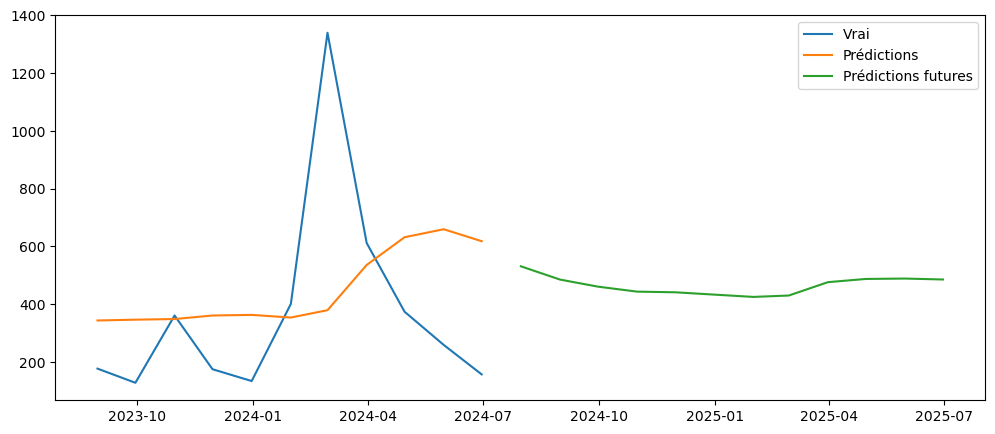

In [121]:
# Affichage des résultats avec une figure plus large
plt.figure(figsize=(12, 5))  # Ajustez la taille de la figure ici
plt.plot(df_totalcas.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Vrai')
plt.plot(df_totalcas.index[-len(predictions):], predictions, label='Prédictions')
plt.plot(future_dates, future_predictions, label='Prédictions futures')
plt.legend()

In [123]:
print(future_predictions)

[[531.3546 ]
 [485.34946]
 [460.90234]
 [443.61008]
 [441.38876]
 [433.3011 ]
 [425.32196]
 [430.15686]
 [476.4328 ]
 [487.54584]
 [488.89255]
 [485.65955]]


In [125]:
from sklearn.metrics import r2_score

# Calcul du R^2
r2 = r2_score(y_test, predictions)

print(f'R^2: {r2}')

R^2: -5115272.426429898


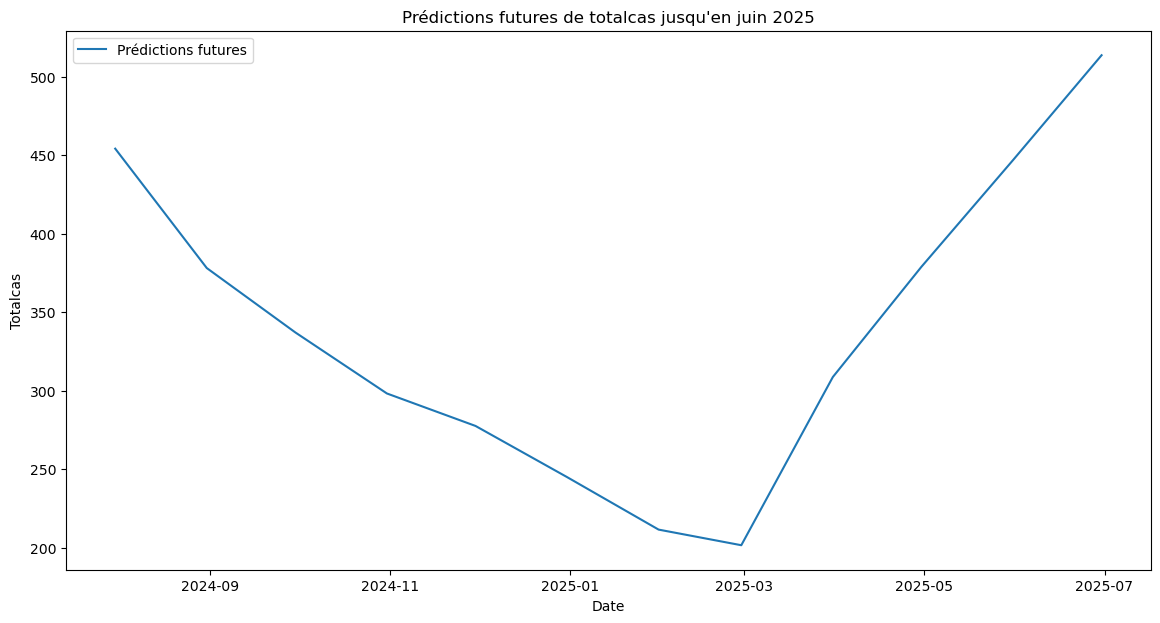

In [95]:
# Affichage des prédictions futures
plt.figure(figsize=(14, 7))  # Ajustez la taille de la figure ici
plt.plot(future_dates, future_predictions, label='Prédictions futures')
plt.legend()
plt.title('Prédictions futures de totalcas jusqu\'en juin 2025')
plt.xlabel('Date')
plt.ylabel('Totalcas')
plt.show()
